## [Regression with a Mohs Hardness Dataset (S3E25)](https://www.kaggle.com/competitions/playground-series-s3e23)
Using Neural Networks to predict the Mohs hardness of a mineral, given its properties.

### Imports

In [1]:
# Basic data manipulation
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
import tensorflow as tf

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import tensorflow_probability as tfp

# Statistical tools
from scipy.stats import randint

## Data Import and Exploratory Data Analysis (EDA)

In [2]:
train = pd.read_csv('data/train.csv') # read train data from csv file (note that this is stored locally, in kaggle you will use the path '/kaggle/input/playground-series-s3e25')
train = train.drop(['id'], axis=1) # drop id column, as it is not needed for training

In [3]:
train.isna().sum() # check for missing values

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [4]:
train.describe() # get summary statistics for each column, useful for detecting outliers

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


Now that we know that the training data has no severe outliers or non-numeric values, we can plot the correlation to see how variables influence each other.

<AxesSubplot:>

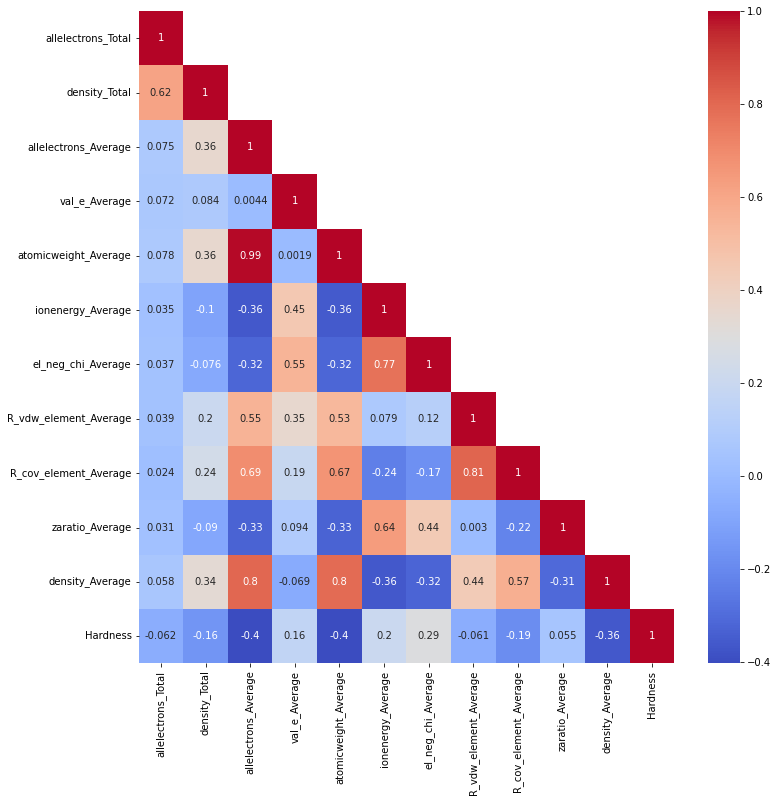

In [5]:

# Plotting correlation matrix for each column

plt.figure(figsize=(12,12)) # set figure size so annotations are not cut off
corr = train.corr() # get correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool), k=1) # create mask to hide upper triangle of plot (as it is a mirror image of the lower triangle)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm') # plot correlation matrix with seaborn (sns)

In [6]:
#Here is a nice way of getting columns for the training data and seperating the target column

features = train.columns.to_list()[:-1] # get list of features (all columns except target)
target = train.columns.to_list().pop(-1) # get target column

#Sanity check
print(features)
print(target)

['allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average']
Hardness


In [7]:
X = train[features] # define X as all input features
y = train[target] # define y as target column ('Hardness')

### Neural Network Regression

**Why use Neural Networks in this Competition:**
1. Alignment with Evaluation Metrics: TensorFlow's capability to implement custom loss functions (like median absolute error) ensures direct alignment with the competition's scoring metric, leading to more effective model optimization.

2. Handling Complex Relationships: Neural networks are adept at capturing complex, non-linear relationships in the data, which is relevant given the diverse chemical and physical features.

3. Advanced Regularization Techniques: TensorFlow supports advanced regularization methods like dropout and batch normalization, enhancing model generalization and preventing overfitting.

**Why is a Custom Loss Function Important?**

In short, so that the loss function can be compatible with the TensorFlow framework. In the context of neural networks, the loss function has to be differentiable (or approximately differentiable) for the network to learn during the backpropagation steps.

In [8]:
# Custom Loss Function defined using tensorflow probability (tfp) in order to use it with our TF neural network model
def mae_loss(y_true, y_pred):
    '''
    Custom loss function for this competition.
    input: y_true (true values), y_pred (predicted values)
    output: loss value, calculated as the 50th percentile (median) of the absolute difference between y_true and y_pred
    '''
    return tfp.stats.percentile(tf.abs(y_true - y_pred), 50.0)


# Custom metrics function defined using tensorflow probability (tfp) in order to use it with our TF neural network model
def metricfunction (y_true, y_pred):
    '''
    Custom metric function for this competition.
    input: y_true (true values), y_pred (predicted values)
    output: metric value, calculated as the 100th percentile (maximum) of the absolute difference between y_true and y_pred minus the 0th percentile (minimum) of the absolute difference between y_true and y_pred
    '''
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred),q=0)

### Narrowing the Scope 
There are a lot of factors that can impact model preformance, here we will focus on the optimizers as out primary hyperparameter (but feel free to test everything). To do so we will systematically train a bunch of small models to determine what preforms the best. Then we of the best optimizer we wil do a similar process to find ideal hyperparameters.

In [9]:
optimizer_list = [
    tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    tf.keras.optimizers.RMSprop(learning_rate=0.001),
    tf.keras.optimizers.Adam(learning_rate=0.01), #Baseline from other notebooks
    tf.keras.optimizers.Adagrad(learning_rate=0.01),
]

In [10]:
# Define neural network model for the given optimizer
def create_model(optimizer):

    # Model architecture using TF functional API (note the previus layer is passed as an argument to the next layer)
    input_layer = tf.keras.Input(shape=(len(features),))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation ='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    # Model instantiation
    model = tf.keras.Model(inputs = input_layer, outputs = output_layer)
    model.compile(optimizer=optimizer, loss = mae_loss)
    
    return model

# Define callbacks to use for quick training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

# Train models with different optimizers and select the best one
best_score = float('inf')
best_optimizer = None

for optimizer in optimizer_list:
    model = create_model(optimizer)
    history = model.fit(X, y, callbacks=callbacks, epochs=100, validation_split=0.2, verbose=0)

    # Evaluate model, e.g., using validation loss
    val_loss = min(history.history['val_loss'])
    print(f'{optimizer.get_config()["name"]} loss: {val_loss}')
    if val_loss < best_score:
        best_score = val_loss
        best_optimizer = optimizer

print(f'\n\nBest optimizer: {best_optimizer.get_config()["name"]}')



SGD loss: 0.7220759987831116
RMSprop loss: 0.642195999622345
Adam loss: 0.6602358222007751
Adagrad loss: 0.7132433652877808


Best optimizer: RMSprop


### Fine Tuning Hyperparameters

Now that we know the best optimizers, we can finetune the parameters of the model to find one that is performant to use for our final model. In this case we will go with [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

In [11]:
# Define hyperparameter grid for the model
epsilons = [1.5e-4, 1e-5, 1.5e-5] #epsilon is a small constant added to prevent division by zero in the update steps.

# Update early stopping contitions to be more tolerant of plateauing (patience=30)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

best_score = float('inf')
best_params = None
best_model = None

# Train models with different hyperparameters and select the best one
for epsilon in epsilons:
    print(f"Training with epsilon={epsilon}")
    optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)
    model = create_model(optimizer)
    history = model.fit(X, y, callbacks=callbacks, epochs=150, validation_split=0.2, verbose=0)
    
    val_loss = min(history.history['val_loss'])
    if val_loss < best_score:
        best_score = val_loss
        best_params = {'epsilon': epsilon}
        best_model = model  # save the best model

print(f"Best parameters: {best_params}")

print(f'\n\nBest parameters: {best_params}')

Training with epsilon=0.00015
Training with epsilon=1e-05
Training with epsilon=1.5e-05
Best parameters: {'epsilon': 0.00015}


Best parameters: {'epsilon': 0.00015}


### Training the Final Model

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,beta_1=0.5, beta_2=0.999, epsilon=1e-05)
model = create_model(optimizer)
history = model.fit(X, y, callbacks=callbacks, epochs=200, validation_split=0.2, verbose=0)

Plotting the training loss (error)

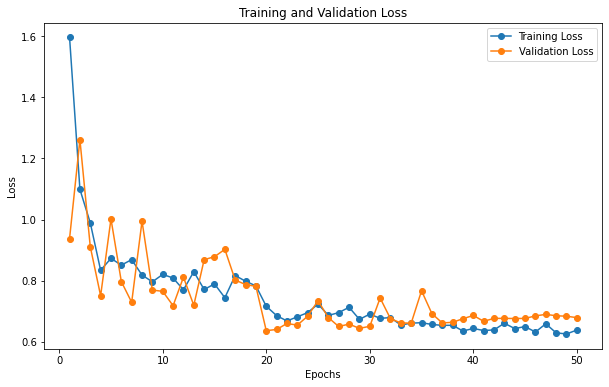

In [13]:
# Extract loss data
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Extract number of epochs
epochs = range(1, len(training_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'o-', label='Training Loss')
plt.plot(epochs, validation_loss, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Making Predicitons on Test Set + Submission

In [14]:
test = pd.read_csv('data/test.csv')
X_submission = test[features] #create the set of features to pass to the trained model to get the predictions

In [15]:
preds = []
preds = model.predict(X_submission) #get the predictions
preds = pd.DataFrame(preds, columns=['target']) #convert the predictions to a dataframe to concatenate with the id column

217/217 [==============================] - 0s 1ms/step


In [16]:
submission = pd.concat([test['id'], preds], axis=1) #concatenate the id and predictions dataframes
submission.to_csv('submission.csv', index=False) #create the submission csv file without the index column

### Thats it!!

After running this last cell, you should have a submission file that you can upload to Kaggle! 